## This notebook test the effect of our hysteresis model - how they affect BOL voltage

In [14]:
# magic lines that avoid re-start 
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
import pybamm as pb;import pandas as pd   ;import numpy as np;import os;import matplotlib.pyplot as plt;import os;#import imageio
from scipy.io import savemat,loadmat;from pybamm import constants,exp;import matplotlib as mpl; # or we can set import matplotlib.pyplot as plt then say 'mpl.rc...'
import openpyxl
import traceback
import multiprocessing
import scipy.optimize
import random;import time, signal
fs=10;
font = {'family' : 'DejaVu Sans','size'   : fs}
mpl.rc('font', **font)

# Add path to system to ensure Fun_NC can be used
import sys  
str_path_0 = os.path.abspath(os.path.join(pb.__path__[0],'..'))
str_path_1 = os.path.abspath(
    os.path.join(str_path_0,"Reproduce_Li2024"))
sys.path.append(str_path_1) 
Path_Input = os.path.expanduser(
    "~/EnvPBGEM_NC/SimSave/InputData/") # for Linux

# import all functions 
from Fun_NC import * 


In [41]:
SaveFig_Path = os.path.expanduser("~/EnvPBGEM_NC/SimSave/Li2024_Results/SaveFig")
Target = "Compare_hysteresis"
target_folder = os.path.join(SaveFig_Path, Target)
if not os.path.exists(target_folder):
    os.makedirs(target_folder)

In [16]:
model_sei_no = pb.lithium_ion.DFN(
    options={
    "SEI": "interstitial-diffusion limited",
    "SEI on cracks": "true",
    
    "lithium plating": "none",
    "lithium plating porosity change":"false",
    "particle mechanics": "constant cracks",
    "loss of active material": "none",

    "contact resistance": "true",
    "open-circuit potential": "single",
    "SEI film resistance": "distributed", 
    "SEI porosity change": "true",
    "thermal": "lumped",  }, )
model_sei_hy = pb.lithium_ion.DFN(
    options={
    "SEI": "interstitial-diffusion limited",
    "SEI on cracks": "true",
    
    "lithium plating": "none",
    "lithium plating porosity change":"false",
    "particle mechanics": "constant cracks",
    "loss of active material": "none",

    "contact resistance": "true",
    "open-circuit potential": "current sigmoid",
    "SEI film resistance": "distributed", 
    "SEI porosity change": "true",
    "thermal": "lumped",  }, )
Model = [model_sei_no, model_sei_hy]


param = pb.ParameterValues("OKane2023")
para_dict = {
    "Positive electrode LAM constant proportional term [s-1]": 1e-16,
    #'Initial electrolyte excessive amount ratio':1.0, 
    "Contact resistance [Ohm]": 0.0115,
    'Inner SEI lithium interstitial diffusivity [m2.s-1]':2.35555E-18, 

    'Outer SEI partial molar volume [m3.mol-1]':4E-05,
    "SEI growth activation energy [J.mol-1]":1e4,
    "Negative electrode diffusivity activation energy [J.mol-1]":6e4,
    "Positive electrode diffusivity activation energy [J.mol-1]":1.2e4,
}
for key, value in para_dict.items():
    param.update({key: value})

V_max = 4.2;        V_min = 2.5
exp_0p1C_text = [ (
    f"Discharge at 0.5C until {V_max-0.2}V", # start from discharge as it is easier for unbalanced cells
    f"Charge at 0.3C until {V_max}V",
    f"Hold at {V_max}V until C/100",
    "Rest for 1 hours", 
    # 0.1C cycle 
    f"Discharge at 0.1C until {V_min} V",  
    "Rest for 3 hours",  
    f"Charge at 0.1C until {V_max} V",
    f"Hold at {V_max}V until C/100",
    "Rest for 1 hours",
    ) ] 

experiment = pb.Experiment(exp_0p1C_text * 1) 
var_pts = {
    "x_n": 10,  # negative electrode
    "x_s": 5,  # separator 
    "x_p": 5,  # positive electrode
    "r_n": 100,  # negative particle
    "r_p": 20,  # positive particle
}


In [17]:
Sol = []
for model in Model:
    sim = pb.Simulation(
        model, 
        experiment = experiment,
        parameter_values=param,
        solver=pb.CasadiSolver(return_solution_if_failed_early=True),
        var_pts=var_pts, )
    sol = sim.solve(calc_esoh=False,)
    Sol.append(sol)

At t = 539.838 and h = 9.61662e-14, the corrector convergence failed repeatedly or with |h| = hmin.


In [18]:
len(Sol[0].cycles)

1

In [19]:
# define global index and dict for all experiment data - prepare for read!
Exp_Path = [
    "Expt 1 - Si-based Degradation/",
    "Expt 2,2 - C-based Degradation 2/",
    "Expt 3 - Cathode Degradation and Li-Plating/",
    "Expt 4 - Drive Cycle Aging (Control)/",
    "Expt 5 - Standard Cycle Aging (Control)/",]
Exp_head = [
    "Expt 1",
    "Expt 2,2",
    "Expt 3",
    "Expt 4",
    "Expt 5",]
Exp_1_Cell = ["A","B","J","D","E","F","K","L","M"];
Exp_1_Temp = {
    "A":"10","B":"10","J":"10",
    "D":"25","E":"25","F":"25",
    "K":"40","L":"40","M":"40",}
Temp_Cell_Exp_1 = {
    "10":["A","B","J"],
    "25":["D","E","F"],
    "40":["K","L","M"],}
Exp_2_Cell = ["A","B","C","D","E","F"];
Exp_2_Temp = {
    "A":"10","B":"10",
    "C":"25","D":"25",
    "E":"40","F":"40",}
Temp_Cell_Exp_2 = {
    "10":["A","B"],
    "25":["C","D"],
    "40":["E","F"],}
Exp_3_Cell = ["A","B","C","D","E","F","G","H","I"]
Exp_3_Temp = {
    "A":"10","B":"10","C":"10",
    "D":"25","E":"25","F":"25",
    "G":"40","H":"40","I":"40"}
Temp_Cell_Exp_3 = {
    "10":["A","B","C"],
    "25":["D","E","F"],
    "40":["G","H","I"],}
Exp_4_Cell = ["A","B","C","D","E","F","G","H"];
Exp_4_Temp = {
    "A":"10","B":"10","C":"10",
    "D":"25","E":"25",
    "F":"40","G":"40","H":"40",}
Temp_Cell_Exp_4 = {
    "10":["A","B","C"],
    "25":["D","E",],
    "40":["F","G","H"],}
Exp_5_Cell = ["A","B","C","D","E","F","G","H"];
Exp_5_Temp = {
    "A":"10","B":"10","C":"10",
    "D":"25","E":"25",
    "F":"40","G":"40","H":"40",}
Temp_Cell_Exp_5 = {
    "10":["A","B","C"],
    "25":["D","E",],
    "40":["F","G","H"],}
Exp_All_Cell  = [Exp_1_Cell,Exp_2_Cell,Exp_3_Cell,Exp_4_Cell,Exp_5_Cell]
Exp_Temp_Cell = [Exp_1_Temp,Exp_2_Temp,Exp_3_Temp,Exp_4_Temp,Exp_5_Temp]
Temp_Cell_Exp_All = [Temp_Cell_Exp_1,Temp_Cell_Exp_2,Temp_Cell_Exp_3,Temp_Cell_Exp_4,Temp_Cell_Exp_5]
Mark_Cell_All = [
    {
    "A":"o","B":">","J":"v",
    "D":"o","E":">","F":"v",
    "K":"o","L":">","M":"v",},
    {
    "A":"10","B":"10",
    "C":"25","D":"25",
    "E":"40","F":"40",},
    {
    "A":"o","B":">","C":"v",
    "D":"o","E":">","F":"v",
    "G":"o","H":">","I":"v",},
    {
    "A":"o","B":">","C":"v",
    "D":"o","E":">",
    "F":"o","G":">","H":"v",},
    {
    "A":"o","B":">","C":"v",
    "D":"o","E":">",
    "F":"o","G":">","H":"v",}]
Color_Cell_All = [
    {
    "A":[2/255, 3/255, 226/255,0.7],"B":[2/255, 3/255, 226/255,0.7],"J":[2/255, 3/255, 226/255,0.7],
    "D":[0, 0, 0,0.7],"E":[0, 0, 0,0.7],"F":[0, 0, 0,0.7],
    "K":[1,0,0,0.4],"L":[1,0,0,0.4],"M":[1,0,0,0.4],},
    {
    "A":[2/255, 3/255, 226/255,0.7],"B":[2/255, 3/255, 226/255,0.7],
    "D":[0, 0, 0,0.7],"C":[0, 0, 0,0.7],
    "E":[1,0,0,0.4],"F":[1,0,0,0.4],},
    {
    "A":[2/255, 3/255, 226/255,0.7],"B":[2/255, 3/255, 226/255,0.7],"C":[2/255, 3/255, 226/255,0.7],
    "D":[0, 0, 0,0.7],"E":[0, 0, 0,0.7],"F":[0, 0, 0,0.7],
    "G":[1,0,0,0.4],"H":[1,0,0,0.4],"I":[1,0,0,0.4],},
    {
    "A":[2/255, 3/255, 226/255,0.7],"B":[2/255, 3/255, 226/255,0.7],"C":[2/255, 3/255, 226/255,0.7],
    "D":[0, 0, 0,0.7],"E":[0, 0, 0,0.7],
    "F":[1,0,0,0.4],"G":[1,0,0,0.4],"H":[1,0,0,0.4],},
    {
    "A":[2/255, 3/255, 226/255,0.7],"B":[2/255, 3/255, 226/255,0.7],"C":[2/255, 3/255, 226/255,0.7],
    "D":[0, 0, 0,0.7],"E":[0, 0, 0,0.7],
    "F":[1,0,0,0.4],"G":[1,0,0,0.4],"H":[1,0,0,0.4],}]


In [20]:
# load experiment data
Path_NiallDMA = os.path.expanduser("~/EnvPBGEM_NC/SimSave/InputData/") 

Exp_no = 3
Temp_Cell_Exp3 = Temp_Cell_Exp_All[Exp_no-1] 
Exp_3_AllData = Read_Exp(
    Path_NiallDMA,Exp_All_Cell[Exp_no-1],
    Exp_Path,Exp_head,Exp_Temp_Cell[Exp_no-1],
    Exp_no-1)

Finish reading Experiment!


In [23]:
# also need C/10 charge curves  - pick Exp-3, cell D, E, F (aged at 25degC)
file_save_D = (
    Path_Input + "Expt 3 - Cathode Degradation and Li-Plating/0.1C Voltage Curves/cell D/"
    + "Expt 3 - cell D - RPT0 - 0.1C charge data.csv")
file_save_E = (
    Path_Input + "Expt 3 - Cathode Degradation and Li-Plating/0.1C Voltage Curves/cell E/"
    + "Expt 3 - cell E - RPT0 - 0.1C charge data.csv")
file_save_F = (
    Path_Input + "Expt 3 - Cathode Degradation and Li-Plating/0.1C Voltage Curves/cell F/"
    + "Expt 3 - cell F - RPT0 - 0.1C charge data.csv")
File_save = [file_save_D, file_save_E, file_save_F]
def Read_C_10_Charge(file_save):
        cell = pd.read_csv(file_save)
        cell["Time (h)"] = (
            cell["Time (s)"] - 
            cell["Time (s)"].iloc[0]) / 3600 # 
        """ cell["Charge (A.h)"] = (
            cell["Charge (mA.h)"] - 
            cell["Charge (mA.h)"].iloc[0]) / 1000 """
        
        return cell
Cell_DEF_exp3_BOL_C_10_Charge = []
for i in range(3):
        Cell_DEF_exp3_BOL_C_10_Charge.append(Read_C_10_Charge(File_save[i]))

#### Plot C/10 discharge voltage curve at BOL. Note that because it is BOL, different expeirments and ageing temperature should not matter.  

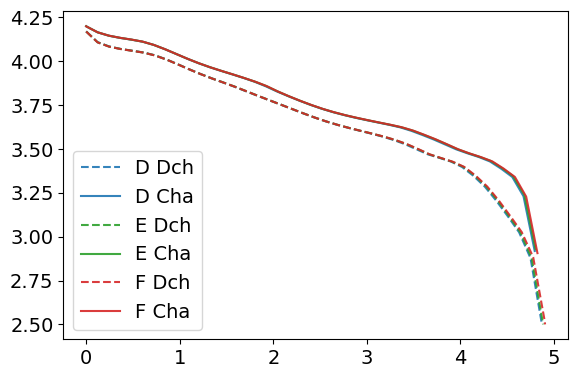

In [31]:
font = {'family' : 'DejaVu Sans','size'   : 14}
mpl.rc('font', **font)

LS = ["-", "--"]
ps_num = 40; T_deg = 10; 
Default_Colors_Alpha = [
    [31/255, 119/255, 180/255, 0.9], # like blue
    [44/255, 160/255, 44/255,  0.9], # like green  
    [214/255, 39/255, 40/255,  0.9], # like red
    [255/255, 127/255, 14/255, 0.9],]# like orange 

color_exp = [0, 0, 0, 0.25];  marker_exp = "v"

fig, axs = plt.subplots(figsize=(6,4),tight_layout=True)

count = 0
for i, cell in enumerate(["D", "E", "F",]):
    # plot less points for discharge
    x_data = (np.array(
        Exp_3_AllData[cell]["0.1C voltage"][f"RPT0"]["Charge (mA.h)"])/1000).tolist()
    y_data = np.array(
        Exp_3_AllData[cell]["0.1C voltage"][f"RPT0"]["Voltage (V)"]).tolist()
    step = len(x_data) // int(ps_num) 
    x_data_sliced = x_data[::step] + [x_data[-1]]
    y_data_sliced = y_data[::step] + [y_data[-1]]
    if i == 0:
        str_label = "Exp - Dch"
    else:
        str_label = None
    axs.plot(
        x_data_sliced, y_data_sliced, color=Default_Colors_Alpha[i],
        linestyle = "--", label=cell+ " Dch") # marker="v", 
    
    # plot less points for discharge

    x_data = np.array(
       Cell_DEF_exp3_BOL_C_10_Charge[i]["Charge (mA.h)"])/1000
    x_data = x_data[-1] - x_data
    x_data = x_data.tolist()
    y_data = np.array(
        Cell_DEF_exp3_BOL_C_10_Charge[i]["Voltage (V)"]).tolist()
    step = len(x_data) // int(ps_num) 
    x_data_sliced = x_data[::step] + [x_data[-1]]
    y_data_sliced = y_data[::step] + [y_data[-1]]
    if i == 0:
        str_label = "Exp - Cha"
    else:
        str_label = None
    axs.plot(
        x_data_sliced, y_data_sliced, color=Default_Colors_Alpha[i],
        linestyle = "-",  label=cell+ " Cha") # marker="s",
axs.legend()    


### Because the C/10 charge and discharge curves of these 3 cells are on top of each other, we just pick cell E to compare with the model

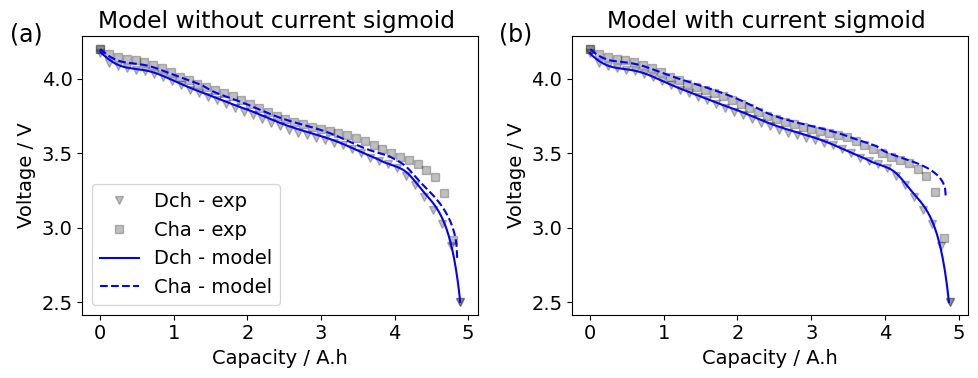

In [42]:
# plot hysteresis
fs = 14
font = {'family' : 'DejaVu Sans','size'   : fs}
mpl.rc('font', **font)

LS = ["-", "--"]; color_exp = [0, 0, 0, 0.25]; 

fig, axs = plt.subplots(1,2, figsize=(10,4),tight_layout=True)
for i in range(2):
    # plot experiment - cell E
    cell = "E"
    x_data = (np.array(
        Exp_3_AllData[cell]["0.1C voltage"][f"RPT0"]["Charge (mA.h)"])/1000).tolist()
    y_data = np.array(
        Exp_3_AllData[cell]["0.1C voltage"][f"RPT0"]["Voltage (V)"]).tolist()
    step = len(x_data) // int(ps_num) 
    x_data_sliced = x_data[::step] + [x_data[-1]]
    y_data_sliced = y_data[::step] + [y_data[-1]]
    axs[i].plot(
        x_data_sliced, y_data_sliced, color=color_exp,
        linestyle = "none", marker="v", label="Dch - exp") # 
    x_data = np.array(
       Cell_DEF_exp3_BOL_C_10_Charge[i]["Charge (mA.h)"])/1000
    x_data = x_data[-1] - x_data
    x_data = x_data.tolist()
    y_data = np.array(
        Cell_DEF_exp3_BOL_C_10_Charge[i]["Voltage (V)"]).tolist()
    step = len(x_data) // int(ps_num) 
    x_data_sliced = x_data[::step] + [x_data[-1]]
    y_data_sliced = y_data[::step] + [y_data[-1]]
    axs[i].plot(
        x_data_sliced, y_data_sliced, color=color_exp,
        linestyle = "none", marker="s",  label="Cha - exp") # 
    
    axs[i].set_xlabel("Capacity / A.h")
    axs[i].set_ylabel(r'Voltage / V')

# plot model without current sigmoid 
step_dc = Sol[0].cycles[0].steps[4]
axs[0].plot(
    step_dc["Discharge capacity [A.h]"].entries - 
    step_dc["Discharge capacity [A.h]"].entries[0],
    step_dc["Terminal voltage [V]"].entries,
    color = "b",
    linestyle = LS[0], label = "Dch - model")
step_ch = Sol[0].cycles[0].steps[6]
axs[0].plot(
    step_ch["Discharge capacity [A.h]"].entries - 
    step_ch["Discharge capacity [A.h]"].entries[-1],
    step_ch["Terminal voltage [V]"].entries,
    color = "b",
    linestyle = LS[1], label = "Cha - model")
axs[0].set_title("Model without current sigmoid ",loc='center') 

# plot model with current sigmoid 
step_dc = Sol[1].cycles[0].steps[4]
axs[1].plot(
    step_dc["Discharge capacity [A.h]"].entries - 
    step_dc["Discharge capacity [A.h]"].entries[0],
    step_dc["Terminal voltage [V]"].entries,
    color = "b",
    linestyle = LS[0], label = "Discharge - model")
step_ch = Sol[1].cycles[0].steps[6]
axs[1].plot(
    step_ch["Discharge capacity [A.h]"].entries - 
    step_ch["Discharge capacity [A.h]"].entries[-1],
    step_ch["Terminal voltage [V]"].entries,
    color = "b",
    linestyle = LS[1], label = "Charge - model")
axs[1].set_title("Model with current sigmoid ",loc='center') 

axs[0].legend(loc='best',)

labels = ["(a)", "(b)"]
for i in range(2):   
    axs[i].text(
        -0.10, 1.05, 
        labels[i], transform=axs[i].transAxes, 
        fontsize=fs+3,  # fontweight='bold', 
        va='top', ha='right')

plt.savefig(
    target_folder + 
    f"/Compare_C_10_Voltage_charge_discharge_w_wo_current_sigmoid.svg")